In [1]:
import numpy as np
import bisect as bisect
from scipy import interpolate
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

# FX Forward Rate Dynamics

Assume the following dynamics for the FX rate under the risk-neutral measure $Q$:

$$ dS_t=(r^d-r^f)S_tdt+\sigma S_tdW_t^Q$$

and the analytic solution for $S_t$: 

$$ S_t=S_0 e^{(r^d-r^f-\frac{\sigma^2}{2})t+\sigma W^Q_t}$$

### Garman-Kohlhagen PDE for FX derivatives

$$
\frac{\partial V}{\partial t} + (r^d-r^f)S_t\frac{\partial V}{\partial S} + \frac{\sigma^2}{2}S_t^2\frac{\partial^2 V}{\partial S^2} - r^d V = 0
\\
$$

With boundary conditions $V(S_T,T)=h(S_T)$ and $V(0,t)=0$.

Also, by Feynman-Kac theorem under measure $Q$, $V$ satisfies:

$$V(S_t,t)=D^d(t,T)\mathbb{E}^Q_t\Big[V(S_T,T)\Big]$$

### Closed Form Solution for a FX Call/Put

$$
BS(S_t,t,T,K,D^d,D^f,\sigma,\omega)=D(t,T)^d\omega\Big[S_t\frac{D(t,T)^f}{D(t,T)^d}\Phi(\omega d_1)-K\Phi(\omega d_2)\Big]\\
$$

$$=D(t,T)^d\omega\Big[F(t,T)\Phi(\omega d_1)-K\Phi(\omega d_2)\Big]$$

Where $\omega=1$ for a call and $\omega=-1$ for a put.

$$d_{1,2}=\frac{log(F/K)\pm \frac{\sigma^2}{2}(T-t)}{\sigma\sqrt{T-t}}$$

### FX Options Put/Call Parity

$$C_t-P_t=D^d(t,T)[F(t,T)-K]$$


### Pathwise Differentials FX Call

$$S_{T_2} = S_{T_1} exp \left[-r^f- \frac{\sigma^2}{2} \left( {T_2} - {T_1} \right) + \sigma \left( W^Q_{T_2} - W^Q_{T_1} \right)  \right]$$

so

$$\frac { \partial \left( S_{T_2} - K  \right)^+} {S_{T_1}} = 1_{\left\{S_{T_2} > K\right\}} \frac{S_{T_2}}{S_{T_1}}$$

### CVA 

$$\text{CVA}_t = \mathbb{E}_t\Bigg[(1-R_{cp})\int_t^T D_t(s)FV^{+}(s)SP_{us}(s)PD_{cp}(s)ds\Bigg]$$

We assume the discount factor (bond price):
$$D(t,T)=e^{-\int^T_t rds}$$

Let's change $FV(s)$ for the positive forward value of a derivative $V(t,S_t)$:

$$\text{CVA}_t = \mathbb{E}_t\Bigg[(1-R_{cp})\int_t^T D(u,t)V^{+}(u,S_u)SP_{us}(u)PD_{cp}(u)du\Bigg]$$


$$=(1-R_{cp})\int_t^T D(t,u)\mathbb{E}_t[V^{+}(u,S_u)]\mathbb{E}_t[SP_{us}(u)]\mathbb{E}_t[PD_{cp}(u)]du$$


$$=(1-R_{cp})\int_t^T D(t,u)D(u,T)\mathbb{E}_t[V^{+}(T,S_T)]\mathbb{E}_t[SP_{us}(u)]\mathbb{E}_t[PD_{cp}(u)]du$$


$$=(1-R_{cp})\int_t^T D(t,T)\mathbb{E}_t[V^{+}(T,S_T)]\mathbb{E}_t[SP_{us}(u)]\mathbb{E}_t[PD_{cp}(u)]du$$


$$=(1-R_{cp})V^{+}(t,S_t)\int_t^T\mathbb{E}_t[SP_{us}(u)]\mathbb{E}_t[PD_{cp}(u)]du$$


For a forward contract, the positive value is the value of a FX call option:

$$\text{CVA}_t =(1-R_{cp})C(t,S_t)\int_t^T\mathbb{E}_t[SP_{us}(u)]\mathbb{E}_t[PD_{cp}(u)]du$$



## 1. FX Call Price: Closed Formula / Garman-Kohlhagen

In [2]:

def bsFXPrice(dynamics,contract):
    S0, vol, rd, rf= dynamics.S0, dynamics.sigma, dynamics.rd, dynamics.rf
    K, T = contract.K, contract.T 
    F=S0*np.exp((rd-rf)*T)
    d1 = (np.log(F/K) + (0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(F/K) - (0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return S0*np.exp(-rf*T) * norm.cdf(d1) - K*np.exp(-rd*T) * norm.cdf(d2)

def bsFXDelta(dynamics,contract):
    S0, vol, rd, rf= dynamics.S0, dynamics.sigma, dynamics.rd, dynamics.rf
    K, T = contract.K, contract.T
    F=S0*np.exp((rd-rf)*T)
    d1 = (np.log(F/K) + 0.5 * vol * vol * T) / (vol * np.sqrt(T))
    return np.exp((-rf)*T)*norm.cdf(d1)

## 2. Parameters: Dynamics, Contract, FD, MC 

In [3]:
# Initialize values for the Dynamics for debugging purposes

class Dynamics:
    pass
fxrate = Dynamics()
fxrate.rd = 0.04
fxrate.rf = 0.02
fxrate.sigma = 0.1
fxrate.S0=1

class Contract:
    pass

contract = Contract()
contract.T = 1
contract.K=1.05

class FD:
    pass

fd = FD()
fd.SMax=1.35
fd.SMin=0.02
fd.deltat=contract.T/10000
fd.deltas=fxrate.sigma*np.sqrt(fd.deltat) 

class MC:
    pass

mc=MC()
mc.N=1000
mc.M=1000
mc.epsilon=10e-5
mc.seed=0



## 3. FX Call Price: FD Crank-Nicolson  for Garman-Kohlhagen PDE

In [4]:
def call_FX_GK_CrankNicolson(contract,dynamics,FD):
    """
    returns array of all initial short rates,
    and the corresponding array of zero-coupon
    T-maturity bond prices
    """ 
    volcoeff, S0,rf,rd=dynamics.sigma, dynamics.S0, dynamics.rf, dynamics.rd
    
    T,K=contract.T,contract.K

 # SMin and SMax denote the smallest and largest S in the _interior_.
    # The boundary conditions are imposed one step _beyond_, 
    # e.g. at S_lowboundary=SMin-deltaS, not at SMin.
    # To relate to lecture notation, S_lowboundary is S_{-J}
    # whereas SMin is S_{-J+1}

    SMax=FD.SMax
    SMin=FD.SMin
    deltaS=FD.deltas
    deltat=FD.deltat
    N=round(T/deltat)
    
    if abs(N-T/deltat)>1e-12:
        raise ValueError('Bad time step')
    numS=round((SMax-SMin)/deltaS)+1
    if abs(numS-(SMax-SMin)/deltaS-1)>1e-12:
        raise ValueError('Bad time step')
    S=np.linspace(SMax,SMin,numS)    #The FIRST indices in this array are for HIGH levels of S
    S_highboundary=SMax+deltaS

    callprice=np.maximum(S-K,0)
    
    ratio=deltat/deltaS
    ratio2=deltat/deltaS**2
    
    f = 0.5*(volcoeff**2)*S**2  
    g = (rd-rf)*S
    h = -rd 
    
    F = 0.5*ratio2*f+0.25*ratio*g
    G = ratio2*f-0.5*deltat*h
    H = 0.5*ratio2*f-0.25*ratio*g
    
    RHSmatrix = diags([H[:-1], 1-G, F[1:]], [1,0,-1], shape=(numS,numS), format="csr")
    LHSmatrix = diags([-H[:-1], 1+G, -F[1:]], [1,0,-1], shape=(numS,numS), format="csr")
    # diags creates SPARSE matrices
    
    for t in np.arange(N-1,-1,-1)*deltat:
        rhs = RHSmatrix * callprice
    
        #boundary condition vectors.
        #They are nonzero only in the first component:
        rhs[0]=rhs[0]+2*H[0]*(S_highboundary-K) #Boundary
        callprice = spsolve(LHSmatrix, rhs)
    
    return(S, callprice)

### Intermediate Functions for FD Solutions

In [5]:
def two_closest(lst, K): 
    """
    Function that find the closest upper and lower element in an array
    """
    
    pos_arr = lst[(lst-K) > 0]
    neg_arr = lst[(K-lst) > 0]
    
    min_val = neg_arr[(np.abs(neg_arr - K)).argmin()]
    max_val = pos_arr[(np.abs(pos_arr - K)).argmin()]
    
    return min_val, max_val

def interpolate_rate(r_arr, bondprice, r0):
    """
    Find the interpolate value of a bond for a given rate of interest based on grid of values 
    """
    
    r_low, r_high = two_closest(r_arr, r0)
    bond_low = bondprice[np.where(r_arr == r_low)[0][0]]
    bond_high = bondprice[np.where(r_arr == r_high)[0][0]]
    
    x = [r_low, r_high]
    y = [bond_low, bond_high]
    f = interpolate.interp1d(x,y)
    
    return f(r0)


## 4. FX Call Price: MonteCarlo for Garman-Kohlhagen 

In [6]:
def call_FX_GK_MC(contract,dynamics,MC):

    np.random.seed(MC.seed)  #seed the random number generator
    
    # You complete the coding of this function
        
    S0, sigma, rd, rf= dynamics.S0, dynamics.sigma, dynamics.rd, dynamics.rf
    K, T = contract.K, contract.T
    N, M, epsilon = MC.N, MC.M, MC.epsilon
    
    deltat = T/N
    C = []
    SE = []
    
    z = np.random.randn(N,M)
    for S in [S0, S0+epsilon]:
        x = S
        for t in range(N):
            zm = z[t]
            x = x + (rd-rf)*deltat + sigma*zm*np.sqrt(deltat)
        s = x
        # discounted payoff
        payoff = np.maximum(s-K,0)*np.exp(-rd*T)
        C.append(np.mean(payoff))
        SE.append(np.std(payoff, ddof=1)/np.sqrt(M))
    
    call_price = C[0]
    standard_error = SE[0]
    call_delta = (C[1]-C[0])/epsilon
    
        
    return(call_price, standard_error, call_delta)

## 5. FX Call Price: LSM & DML for Garman-Kohlhagen

In [7]:
try:
    %matplotlib notebook
except Exception:
    pass

# import and test
import tensorflow as tf2
print("TF version =", tf2.__version__)

# we want TF 2.x
assert tf2.__version__ >= "2.0"

# disable eager execution etc
tf = tf2.compat.v1
tf.disable_eager_execution()

# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# make sure we have GPU support
print("GPU support = ", tf.test.is_gpu_available())

# import other useful libs
from scipy.stats import norm
from tqdm import tqdm_notebook

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

TF version = 2.4.1
GPU support =  False


#### Part I : Core Functions

##### Feedforward neural network in TensorFlow

In [8]:
def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.set_random_seed(seed)
    
    # input layer
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

#### Explicit backpropagation and twin network

In [9]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

#### Vanilla training loop

In [10]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

#### Differential training loop

In [11]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

#### Combined outer training loop

In [12]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)        

#### Data normalization

In [13]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

#### Putting it all together

In [49]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units = 10, # 20 
                hidden_layers = 3,  # 4
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

#### GK FX Class

# Tak review

In [ ]:
#contract = Contract()
#contract.T = 1
#contract.K = 1.05

In [86]:
class BlackScholesFX:
    
    def __init__(self, 
                 dynamics,
                 contract,
                 T1=0.5,
                 volMult=1.0):
        
        self.dynamics = Dynamics()
        self.dynamics.S0 = dynamics.S0
        self.dynamics.rd = dynamics.rd
        self.dynamics.rf = dynamics.rf
        self.dynamics.sigma = dynamics.sigma
        
        self.contract_T2=Contract()
        self.contract_T2.T = contract.T
        self.contract_T2.K=contract.K
        self.contract_T1= Contract()
        self.contract_T1.T = T1
        self.contract_T1.K=contract.K
        
        self.spot = self.dynamics.S0
        self.vol =  self.dynamics.sigma
        self.rf = self.dynamics.rf
        self.rd = self.dynamics.rd
        self.T1 = T1
        self.T2 = self.contract_T2.T
        self.K = self.contract_T2.K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp((self.rd-self.rf-0.5*vol0*vol0)*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp((self.rd-self.rf-0.5*self.vol*self.vol)*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, np.exp(-self.rd*self.T2)*(S2 - self.K))
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp((self.rd-self.rf-0.5*self.vol*self.vol)*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, np.exp(-self.rd*self.T2)*(S2a - self.K))
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(np.exp(-self.rd*self.T2)*S2 > np.exp(-self.rd*self.T2)*self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(np.exp(-self.rd*self.T2)*S2a > np.exp(-self.rd*self.T2)*self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(np.exp(-self.rd*self.T2)*S2 > np.exp(-self.rd*self.T2)*self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas
    def testSet(self, lower=0.8, upper=1.15, num=1000, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas 
        prices = np.zeros(num)
        deltas = np.zeros(num)
        
        for i in range(num):
            self.dynamics.S0 = spots[i]
            dammy_cont = np.copy(self.contract_T2)
            dammy_cont.T = self.contract_T2.T - self.contract_T1.T
            prices[i] = bsFXPrice(self.dynamics,self.contract_T2-self.contract_T1)
            deltas[i] = bsFXDelta(self.dynamics,self.contract_T2-self.contract_T1)
            #prices[i] = bsFXPrice(self.dynamics,self.contract_T1)
            #deltas[i] = bsFXDelta(self.dynamics,self.contract_T1)
        
        prices = prices.reshape((-1, 1))
        deltas = deltas.reshape((-1, 1))
        return spots, spots, prices, deltas  

In [87]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural approximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    exec_time={}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        exec_time[("standard", size)]=t1-t0
        print("\nStandard Training Time {:.4f}s".format(t1-t0))
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        exec_time[("differential", size)]=t1-t0
        print("\nDifferential Training Time {:.4f}s".format(t1-t0))
    return xAxis, yTest, dydxTest[:, deltidx], predvalues, preddeltas,exec_time

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=True)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

In [88]:
# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 1000    

# go
generator = BlackScholesFX(fxrate,contract)
xAxis, yTest, dydxTest, values, deltas,exec_time = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

# show predicitions
graph("Call-GK", values, xAxis, "", "values %", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Call-GK", deltas, xAxis, "", "deltas%", dydxTest, sizes, True)

using seed 12
simulating training, valid and test sets


AttributeError: attribute 'T' of 'numpy.ndarray' objects is not writable

## 6. Pricing Methods Comparison

In [40]:
start = time.time()
(fxspot, callprice) = call_FX_GK_CrankNicolson(contract,fxrate,fd)
end = time.time()
cn_fd_time=round(end - start,2)

fxrate2 = Dynamics()
fxrate2.rd = 0.04
fxrate2.rf = 0.02
fxrate2.sigma = 0.1
fxrate2.S0 = 1
num_prices = 100
fxspot_mc = np.linspace(fd.SMin,fd.SMax, num_prices)
callprice_mc = []

start = time.time()
for S_ in fxspot_mc:
    fxrate2.S0 = S_
    call,error,delta = call_FX_GK_MC(contract,fxrate2,mc)
    callprice_mc.append(call)
end = time.time()
mc_time=round(end - start,2)

In [41]:
N=1000
s=8192
spot_charts = np.linspace(0.95,1.07, N)
call_fx_cn = np.zeros(N)
call_fx_mc = np.zeros(N)
call_fx_dml= np.zeros(N)
call_fx_snn= np.zeros(N)
call_fx_analytical = np.zeros(N)

callprice_dml=[ c[0] for c in values[("differential", s)].tolist()]
callprice_snn=[ c[0] for c in values[("standard", s)].tolist()]

for i, S_ in enumerate(tqdm(spot_charts)):
    fxrate2.S0=S_
    call_fx_analytical[i]=bsFXPrice(fxrate2,contract)
    call_fx_cn[i]=interpolate_rate(fxspot,callprice,S_)
    call_fx_dml[i]=interpolate_rate(xAxis,callprice_dml,S_)
    call_fx_snn[i]=interpolate_rate(xAxis,callprice_snn,S_)
    call_fx_mc[i]=interpolate_rate(fxspot_mc,callprice_mc,S_)
    
    
    
   

100%|██████████| 1000/1000 [00:00<00:00, 1987.19it/s]


<IPython.core.display.Javascript object>


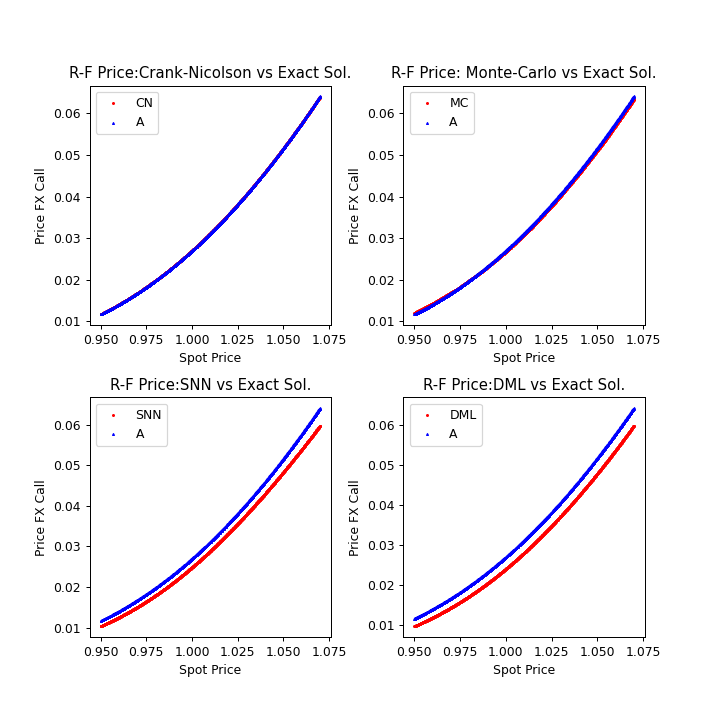

In [42]:
fig = plt.figure(figsize = (8,8))

X = spot_charts
Z1 = call_fx_cn
Z2 = call_fx_mc
Z3 = call_fx_snn
Z4 = call_fx_dml
Z5 = call_fx_analytical

ax1 = fig.add_subplot(221)
plt.subplots_adjust(hspace = 0.3,wspace = 0.3)
for c,m, Z in [('r','o', Z1), ('b','^', Z5)]:
    ax1.scatter(X, Z, c = c,marker = m,s=2)
ax1.legend(["CN","A"],loc="upper left")
ax1.set_xlabel('Spot Price')
ax1.set_ylabel('Price FX Call')
ax1.title.set_text('R-F Price:Crank-Nicolson vs Exact Sol.')

ax2 = fig.add_subplot(222)
plt.subplots_adjust(hspace = 0.3,wspace = 0.3)
for c, m, Z in [('r','o', Z2), ('b','^', Z5)]:
    ax2.scatter(X, Z, c = c, marker = m,s=2)
    
ax2.legend(["MC","A"],loc="upper left")
ax2.set_xlabel('Spot Price')
ax2.set_ylabel('Price FX Call')
ax2.title.set_text('R-F Price: Monte-Carlo vs Exact Sol.')

ax3 = fig.add_subplot(223)
plt.subplots_adjust(hspace = 0.3,wspace = 0.3)
for c, m, Z in [('r','o', Z3), ('b','^', Z5)]:
    ax3.scatter(X, Z, c = c, marker = m,s=2)
    
ax3.legend(["SNN","A"],loc="upper left")
ax3.set_xlabel('Spot Price')
ax3.set_ylabel('Price FX Call')
ax3.title.set_text('R-F Price:SNN vs Exact Sol.')

ax4 = fig.add_subplot(224)
plt.subplots_adjust(hspace = 0.3,wspace = 0.3)
for c, m, Z in [('r','o', Z4), ('b','^', Z5)]:
    ax4.scatter(X, Z, c = c, marker = m,s=2)
ax4.legend(["DML","A"],loc="upper left")
ax4.set_xlabel('Spot Price')
ax4.set_ylabel('Price FX Call')
ax4.title.set_text('R-F Price:DML vs Exact Sol.')

plt.show()

In [21]:
def calc_rmse(exact,est):
    rmse=np.sqrt(((exact-est)**2).mean(axis=0))
    return rmse

In [22]:
txt="{time:.2f} seconds"
txt2="{error:.4f}%"
s=8192
display(pd.DataFrame(data=[[txt.format(time = cn_fd_time),
                            txt2.format(error=calc_rmse(call_fx_analytical,call_fx_cn)*100)],
                           [txt.format(time = mc_time),
                           txt2.format(error =calc_rmse(call_fx_analytical,call_fx_mc)*100)],
                           [txt.format(time = exec_time[("standard", s)]),
                           txt2.format(error =calc_rmse(call_fx_analytical,call_fx_snn)*100)],
                           [txt.format(time = exec_time[("differential", s)]),
                           txt2.format(error =calc_rmse(call_fx_analytical,call_fx_dml)*100)]],
                     index=["FD Crank-Nicolson",
                            "Monte-Carlo","Std NN (n={})".format(s),
                            "Diff NN (n={})".format(s)],
                     columns=["Execution Time", "RMSE"]))

,Execution Time,RMSE
FD Crank-Nicolson,4.51 seconds,0.0041%
Monte-Carlo,4.98 seconds,0.0404%
Std NN (n=8192),2.11 seconds,1.4764%
Diff NN (n=8192),2.59 seconds,1.4827%


## 7. FX Call Price: CVA Computation

We assume the following two functions for the survival probability and the probability of default

$$
SP_{us}(t)=e^{-(\lambda_{us} t)^p}
$$

$$
PD_{cp}(t)=\lambda_{cp} e^{-\lambda_{cp} t}
$$

In [23]:
def survival_func(t,l=1.4,p=4):
    F=np.exp(-(l*t)**p)
    return F
    
    
def default_func(t,l=0.5):
    f=l*np.exp(-l*t)
    return f


<IPython.core.display.Javascript object>


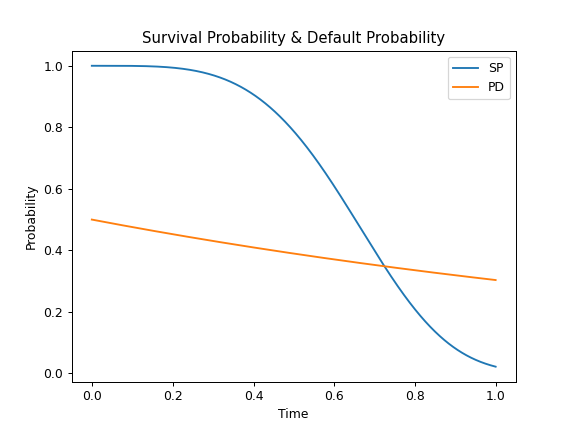

In [24]:
# define a range of x values
x_axis = np.arange(0, 1, 0.001)

# create lists of values
survival_vals = [survival_func(x) for x in x_axis]
default_vals = [default_func(x) for x in x_axis]

# plot the result 
plt.figure()
plt.plot(x_axis, survival_vals,label='SP')
plt.plot(x_axis, default_vals,label='PD')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Survival Probability & Default Probability')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


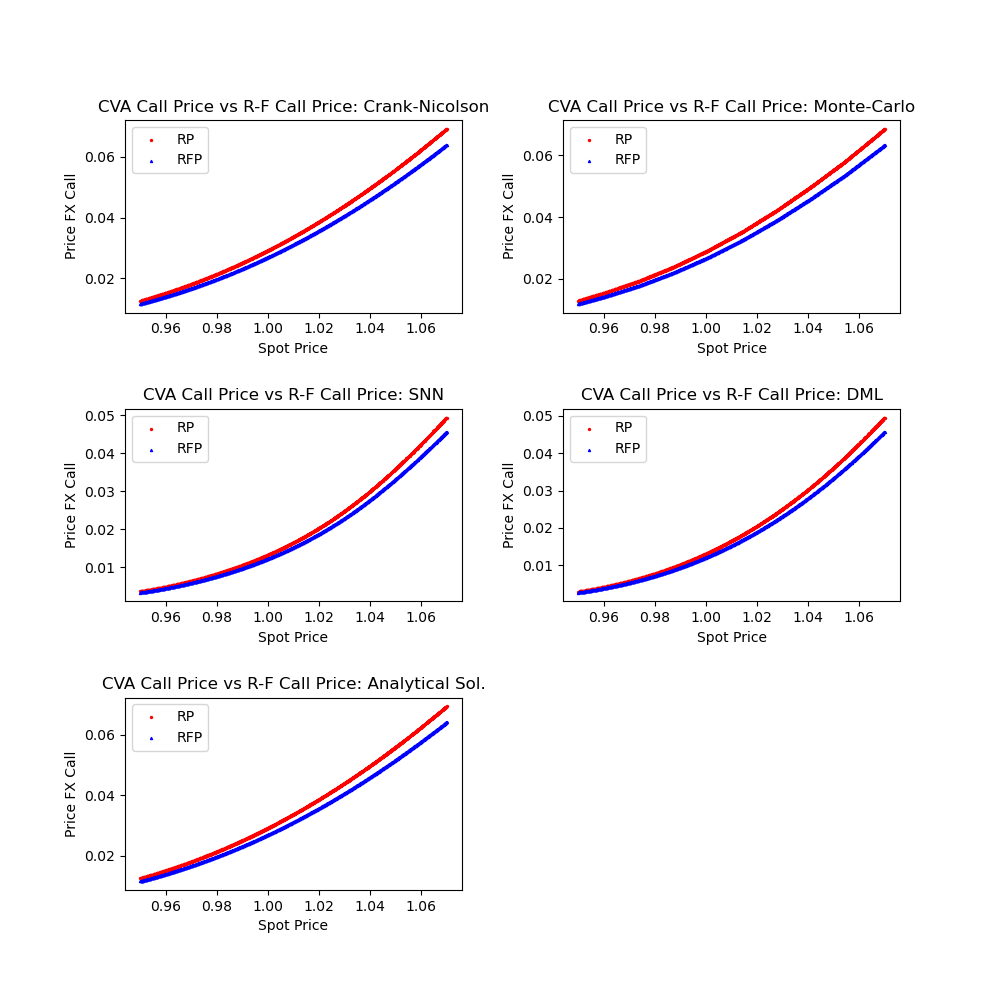

In [103]:
recovery_rate=0.7
maturity=1.0
integral=integrate.quad(lambda x:survival_func(x)*default_func(x),0,maturity)[0]

fig = plt.figure(figsize = (10,10))
X = spot_charts
Z1_cva = [sum(z) for z in zip(((1-recovery_rate)*call_fx_cn*integral).tolist(),call_fx_cn.tolist())]
Z2_cva = [sum(z) for z in zip(((1-recovery_rate)*call_fx_mc*integral).tolist(),call_fx_mc.tolist())]
Z3_cva = [sum(z) for z in zip(((1-recovery_rate)*call_fx_snn*integral).tolist(),call_fx_snn.tolist())]
Z4_cva = [sum(z) for z in zip(((1-recovery_rate)*call_fx_dml*integral).tolist(),call_fx_dml.tolist())]
Z5_cva = [sum(z) for z in zip(((1-recovery_rate)*call_fx_analytical*integral).tolist(),call_fx_analytical.tolist())]

ax1 = fig.add_subplot(321)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c,m, Z in [('r','o', Z1_cva), ('b','^', Z1)]:
    ax1.scatter(X, Z, c = c,marker = m,s=2)
    
ax1.legend(["RP","RFP"],loc="upper left")
ax1.set_xlabel('Spot Price')
ax1.set_ylabel('Price FX Call')
ax1.title.set_text('CVA Call Price vs R-F Call Price: Crank-Nicolson')

ax2 = fig.add_subplot(322)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z2_cva), ('b','^', Z2)]:
    ax2.scatter(X, Z, c = c, marker = m,s=2)
ax2.legend(["RP","RFP"],loc="upper left")
ax2.set_xlabel('Spot Price')
ax2.set_ylabel('Price FX Call')
ax2.title.set_text('CVA Call Price vs R-F Call Price: Monte-Carlo')

ax3 = fig.add_subplot(323)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z3_cva), ('b','^', Z3)]:
    ax3.scatter(X, Z, c = c, marker = m,s=2)
ax3.legend(["RP","RFP"],loc="upper left")
ax3.set_xlabel('Spot Price')
ax3.set_ylabel('Price FX Call')
ax3.title.set_text('CVA Call Price vs R-F Call Price: SNN')

ax4 = fig.add_subplot(324)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z4_cva), ('b','^', Z4)]:
    ax4.scatter(X, Z, c = c, marker = m,s=2)

ax4.legend(["RP","RFP"],loc="upper left")
ax4.set_xlabel('Spot Price')
ax4.set_ylabel('Price FX Call')
ax4.title.set_text('CVA Call Price vs R-F Call Price: DML')


ax5 = fig.add_subplot(325)
plt.subplots_adjust(hspace = 0.5,wspace = 0.3)
for c, m, Z in [('r','o', Z5_cva), ('b','^', Z5)]:
    ax5.scatter(X, Z, c = c, marker = m,s=2)

ax5.legend(["RP","RFP"],loc="upper left")
ax5.set_xlabel('Spot Price')
ax5.set_ylabel('Price FX Call')
ax5.title.set_text('CVA Call Price vs R-F Call Price: Analytical Sol.')


plt.show()